In [2]:
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns

C:\Users\natha\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\natha\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
df = pd.read_csv('basic_prepared_data.csv', keep_default_na=True, delimiter=',', skipinitialspace=True)
df['datetime'] = pd.to_datetime(df['datetime'])
# new time series features
df['month'] = df['datetime'].dt.month
df['day_of_week'] = df['datetime'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
df['quarter'] = df['datetime'].dt.quarter
df.head()

,datetime,taxi_zone,passenger_count,temperature_2m (°C),rain (mm),snow_depth (m),snowfall (cm),wind_speed_10m (km/h),day,week,hour,month,holiday,day_of_week,is_weekend,quarter
0,2022-01-01 00:00:00,4,890.500000,-17.0,0.0,0.64,0.00,8.3,1,Saturday,0,1,New Year's Day,5,1,1
1,2022-01-01 01:00:00,4,793.239130,-15.6,0.0,0.64,0.07,8.0,1,Saturday,1,1,New Year's Day,5,1,1
2,2022-01-01 02:00:00,4,686.500000,-14.7,0.0,0.64,0.07,7.6,1,Saturday,2,1,New Year's Day,5,1,1
3,2022-01-01 03:00:00,4,523.891304,-14.2,0.0,0.64,0.07,7.0,1,Saturday,3,1,New Year's Day,5,1,1
4,2022-01-01 04:00:00,4,351.956522,-12.6,0.0,0.64,0.14,7.0,1,Saturday,4,1,New Year's Day,5,1,1


In [4]:
df.dtypes

datetime                 datetime64[ns]
taxi_zone                         int64
passenger_count                 float64
temperature_2m (°C)             float64
rain (mm)                       float64
snow_depth (m)                  float64
snowfall (cm)                   float64
wind_speed_10m (km/h)           float64
day                               int64
week                             object
hour                              int64
month                             int32
holiday                          object
day_of_week                       int32
is_weekend                        int64
quarter                           int32
dtype: object

In [5]:
# Check and convert categorical columns (one-hot encoded)
categorical_columns = [col for col in df.columns if 'week_' in col or 'holiday_' in col]
for col in categorical_columns:
    df[col] = df[col].astype(int)

# Ensure numerical columns are of the correct type
numerical_columns = ['passenger_count', 'temperature_2m (°C)', 'rain (mm)', 'snow_depth (m)',
                     'snowfall (cm)', 'wind_speed_10m (km/h)']

for col in numerical_columns:
    df[col] = df[col].astype(float)
    
object_columns = df.select_dtypes(['object']).columns
#Convert selected columns to type 'category'
for column in object_columns:
    df[column] = df[column].astype('category')   


df["day"] = df["day"].astype('category') 
df["hour"] = df["hour"].astype('int64')
df["taxi_zone"] = df["taxi_zone"].astype('category') 

df['datetime'] = pd.to_datetime(df['datetime'])

# Display the DataFrame with the correct data types
print(df.dtypes)

datetime                 datetime64[ns]
taxi_zone                      category
passenger_count                 float64
temperature_2m (°C)             float64
rain (mm)                       float64
snow_depth (m)                  float64
snowfall (cm)                   float64
wind_speed_10m (km/h)           float64
day                            category
week                           category
hour                              int64
month                             int32
holiday                        category
day_of_week                       int32
is_weekend                        int64
quarter                           int32
dtype: object


In [6]:
 # check null value
df.isnull().sum()

datetime                 0
taxi_zone                0
passenger_count          0
temperature_2m (°C)      0
rain (mm)                0
snow_depth (m)           0
snowfall (cm)            0
wind_speed_10m (km/h)    0
day                      0
week                     0
hour                     0
month                    0
holiday                  0
day_of_week              0
is_weekend               0
quarter                  0
dtype: int64

In [7]:
#update all columns of type 'numeric'
numeric_columns = df.select_dtypes(['float', 'int']).columns
numeric_columns

Index(['passenger_count', 'temperature_2m (°C)', 'rain (mm)', 'snow_depth (m)',
       'snowfall (cm)', 'wind_speed_10m (km/h)', 'hour', 'month',
       'day_of_week', 'is_weekend', 'quarter'],
      dtype='object')

In [8]:
df.dtypes

datetime                 datetime64[ns]
taxi_zone                      category
passenger_count                 float64
temperature_2m (°C)             float64
rain (mm)                       float64
snow_depth (m)                  float64
snowfall (cm)                   float64
wind_speed_10m (km/h)           float64
day                            category
week                           category
hour                              int64
month                             int32
holiday                        category
day_of_week                       int32
is_weekend                        int64
quarter                           int32
dtype: object

In [9]:
df[numeric_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
passenger_count,1173176.0,1615.859052,2123.251983,0.0,291.0,1022.00,2083.0,38528.00
temperature_2m (°C),1173176.0,-1.303940,9.948569,-38.4,-8.3,-0.90,5.7,23.20
rain (mm),1173176.0,0.038961,0.217745,0.0,0.0,0.00,0.0,5.40
snow_depth (m),1173176.0,0.548796,0.572905,0.0,0.0,0.37,1.1,1.89
snowfall (cm),1173176.0,0.072694,0.276916,0.0,0.0,0.00,0.0,4.76
wind_speed_10m (km/h),1173176.0,5.726533,2.417869,0.0,4.0,5.50,7.1,17.50
hour,1173176.0,11.499942,6.922091,0.0,6.0,11.00,17.0,23.00
month,1173176.0,6.526366,3.448813,1.0,4.0,7.00,10.0,12.00
day_of_week,1173176.0,3.006820,2.001725,0.0,1.0,3.00,5.0,6.00
is_weekend,1173176.0,0.287677,0.452680,0.0,0.0,0.00,1.0,1.00


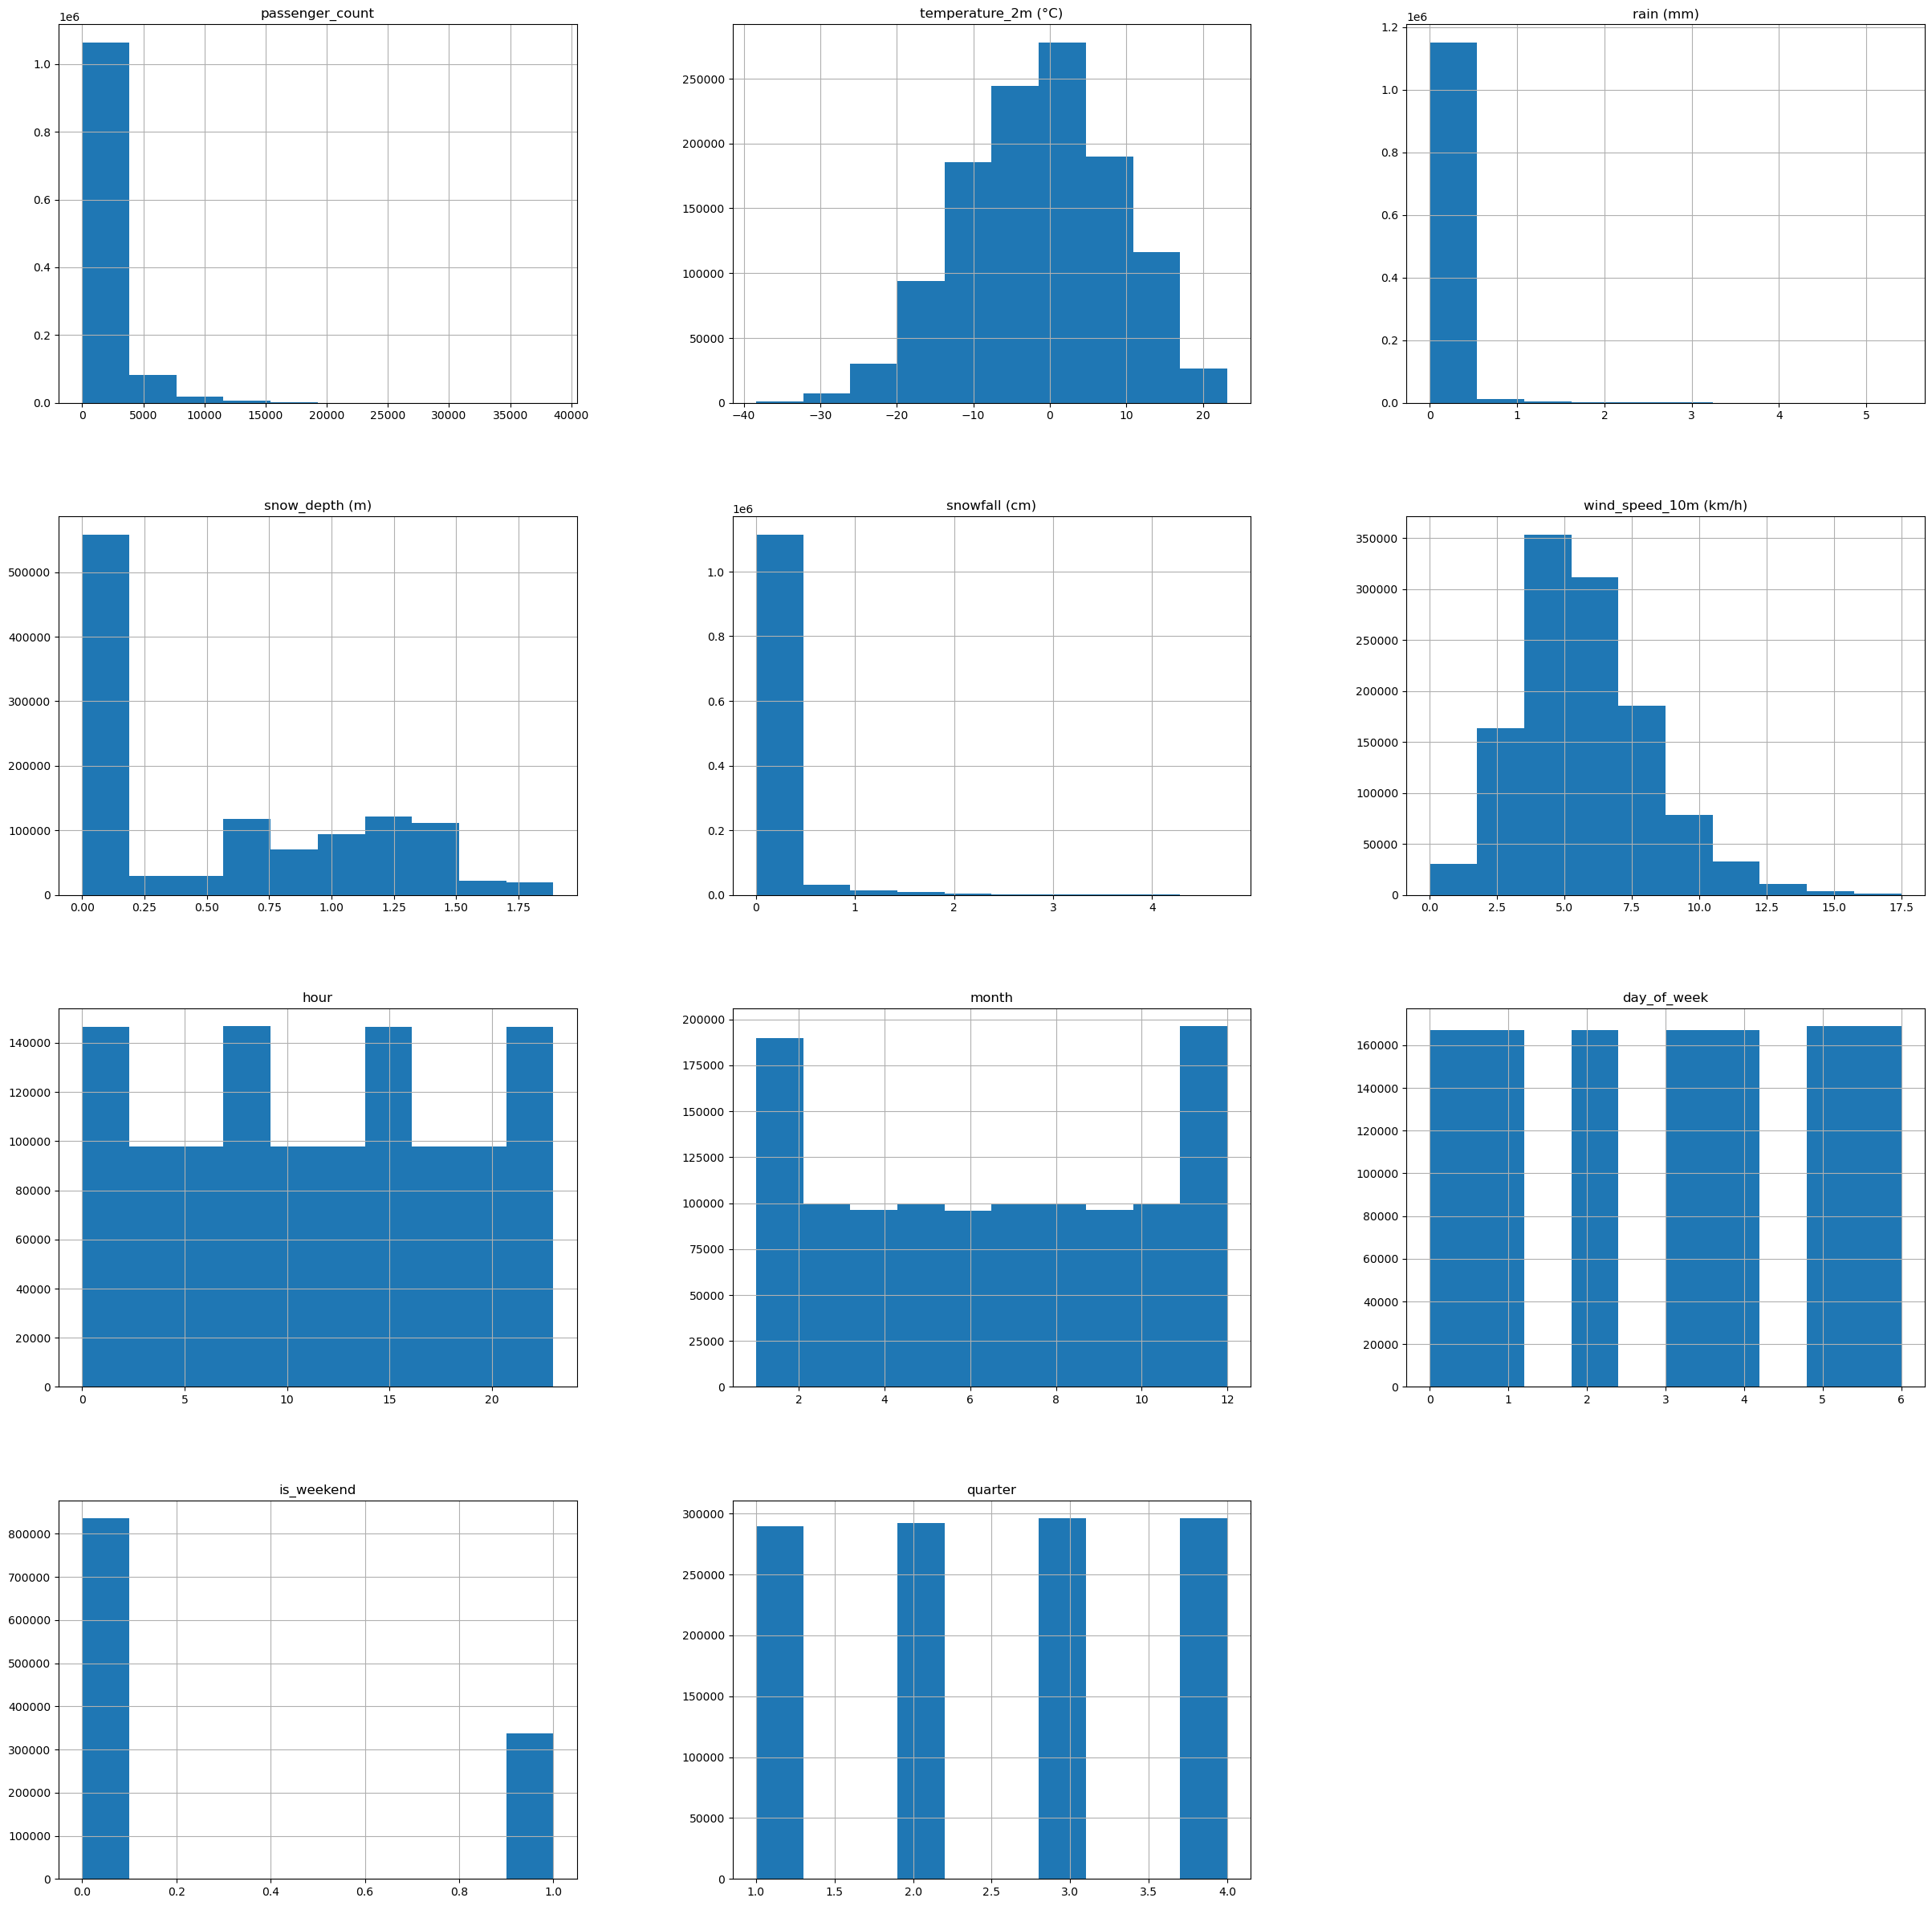

In [9]:
# Plot a histogram summary sheet of the continuous features
df[numeric_columns].hist( figsize=(30,30), bins=10);

In [10]:
cols_to_avg = ['taxi_zone', 'hour', 'passenger_count', 'temperature_2m (°C)', 
               'rain (mm)', 'snow_depth (m)', 'snowfall (cm)', 
               'wind_speed_10m (km/h)']

grouped_taxi_hour = df[cols_to_avg].groupby(['taxi_zone', 'hour']).mean().reset_index()
grouped_taxi_hour.head(3000)

C:\Users\natha\AppData\Local\Temp\ipykernel_29304\4265096975.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_taxi_hour = df[cols_to_avg].groupby(['taxi_zone', 'hour']).mean().reset_index()


,taxi_zone,hour,passenger_count,temperature_2m (°C),rain (mm),snow_depth (m),snowfall (cm),wind_speed_10m (km/h)
0,4,0,840.578308,-6.361644,0.027945,0.549534,0.078247,6.364384
1,4,1,544.142325,-5.731370,0.019589,0.549918,0.071247,5.925068
2,4,2,370.906530,-4.102466,0.016986,0.550247,0.083808,6.009041
3,4,3,228.213428,-1.872466,0.025753,0.550397,0.073932,5.332192
4,4,4,167.737560,0.365205,0.026986,0.550534,0.075082,5.117123
...,...,...,...,...,...,...,...,...
1627,263,19,1546.557534,-5.105342,0.031507,0.548288,0.078342,5.301781
1628,263,20,1216.026027,-5.476575,0.034110,0.548479,0.072973,5.317260
1629,263,21,1108.127397,-5.770685,0.035205,0.548808,0.070767,5.381781
1630,263,22,1027.334247,-6.022603,0.028904,0.549096,0.081315,5.404247


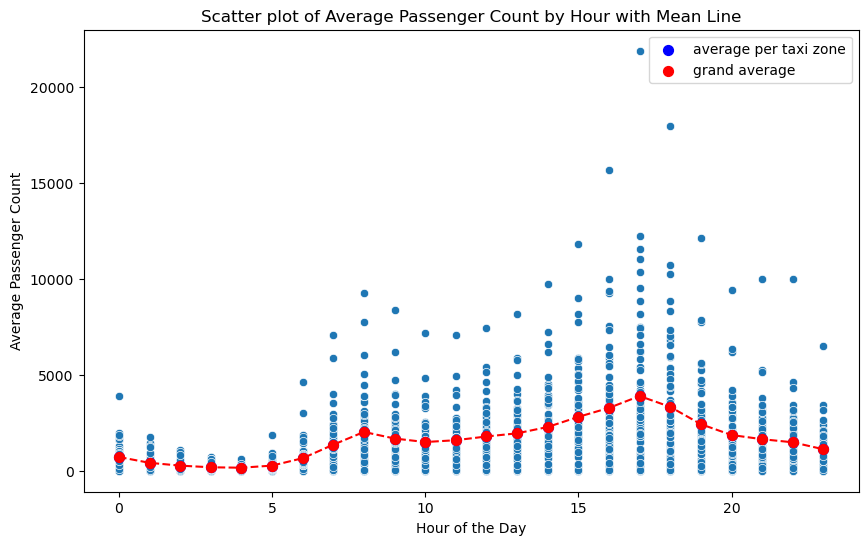

In [11]:
# Create scatter plot
plt.figure(figsize=(10,6))
sns.scatterplot(x='hour', y='passenger_count', data=grouped_taxi_hour)
# Calculate mean of passenger_count for each hour
mean_passenger_count = grouped_taxi_hour.groupby('hour')['passenger_count'].mean()

# Add circle marker to the different taxi zone values
plt.scatter(mean_passenger_count.index, mean_passenger_count.values, color='blue', s=50, label='average per taxi zone')



# Add mean line
plt.plot(mean_passenger_count.index, mean_passenger_count.values, color='red', linestyle='dashed')

# Add circle marker to the mean values
plt.scatter(mean_passenger_count.index, mean_passenger_count.values, color='red', s=50, label='grand average')

# Set plot title and labels
plt.title('Scatter plot of Average Passenger Count by Hour with Mean Line')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Passenger Count')

# Display legend
plt.legend()

plt.show()

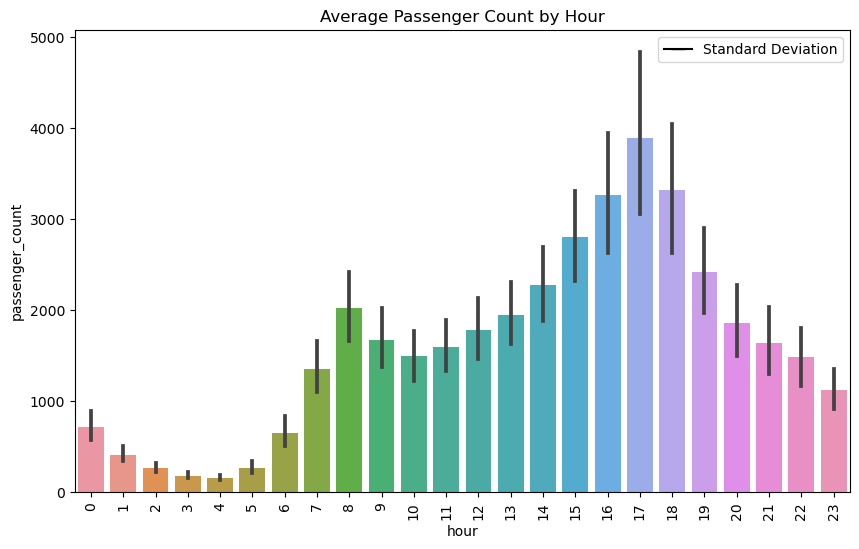

In [12]:
import matplotlib.lines as mlines

# Create the bar plot with error bars
plt.figure(figsize=(10,6))
sns.barplot(x='hour', y='passenger_count', data=grouped_taxi_hour)

# Set the title and rotate the x-axis labels
plt.title('Average Passenger Count by Hour')
plt.xticks(rotation=90)

# Set the lower limit of y-axis to 0
plt.ylim(bottom=0)

# Create a line legend for the standard deviation
error_line = mlines.Line2D([], [], color='black', marker='_', markersize=10, label='Standard Deviation')

# Add the legend to the plot
plt.legend(handles=[error_line])

plt.show()

In [11]:
# Convert 'datetime' to datetime format if it's not already
df['datetime'] = pd.to_datetime(df['datetime'])

# Create a new column 'date' by stripping hour information from 'datetime'
df['date'] = df['datetime'].dt.date

# Group by 'taxi_zone' and 'date', summing 'passenger_count', and average values for other columns
grouped_day = df.groupby(['taxi_zone', 'date']).agg({
    'passenger_count': 'sum',
    'week': 'first',
    'month': 'first',
    'holiday': 'first',
    'temperature_2m (°C)': 'mean',
    'rain (mm)': 'mean',
    'snow_depth (m)': 'mean',
    'snowfall (cm)': 'mean',
    'wind_speed_10m (km/h)': 'mean'
}).reset_index()

grouped_day

C:\Users\natha\AppData\Local\Temp\ipykernel_29304\1550320198.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_day = df.groupby(['taxi_zone', 'date']).agg({


,taxi_zone,date,passenger_count,week,month,holiday,temperature_2m (°C),rain (mm),snow_depth (m),snowfall (cm),wind_speed_10m (km/h)
0,4,2022-01-01,34910.760870,Saturday,1.0,New Year's Day,-11.141667,0.000000,0.645833,0.049583,5.812500
1,4,2022-01-02,32890.000000,Sunday,1.0,No,-10.945833,0.000000,0.648750,0.017500,5.737500
2,4,2022-01-03,32852.847826,Monday,1.0,No,-9.212500,0.000000,0.641250,0.032083,6.904167
3,4,2022-01-04,31432.978261,Tuesday,1.0,No,-8.483333,0.000000,0.675000,0.151667,3.683333
4,4,2022-01-05,31501.239130,Wednesday,1.0,No,-9.983333,0.000000,0.683750,0.014583,4.225000
...,...,...,...,...,...,...,...,...,...,...,...
49635,263,2023-12-27,19219.000000,Wednesday,12.0,No,-7.325000,0.000000,0.750833,0.772917,6.887500
49636,263,2023-12-28,21988.000000,Thursday,12.0,No,-7.033333,0.000000,0.849167,0.000000,8.812500
49637,263,2023-12-29,23156.000000,Friday,12.0,No,-8.295833,0.008333,0.845000,0.253750,7.091667
49638,263,2023-12-30,21776.000000,Saturday,12.0,No,-14.895833,0.000000,0.902083,0.099167,4.120833


In [12]:
# Group by 'taxi_zone' and 'week', average 'passenger_count',
grouped_week = grouped_day.groupby(['taxi_zone', 'week']).agg({
    'passenger_count': 'sum',
    'month': 'first',
    'holiday': 'first',
    'temperature_2m (°C)': 'mean',
    'rain (mm)': 'mean',
    'snow_depth (m)': 'mean',
    'snowfall (cm)': 'mean',
    'wind_speed_10m (km/h)': 'mean'
}).reset_index()


grouped_week

C:\Users\natha\AppData\Local\Temp\ipykernel_29304\2247968854.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_week = grouped_day.groupby(['taxi_zone', 'week']).agg({


,taxi_zone,week,passenger_count,month,holiday,temperature_2m (°C),rain (mm),snow_depth (m),snowfall (cm),wind_speed_10m (km/h)
0,4,Friday,3.728622e+06,1.0,No,-1.246034,0.040905,0.551651,0.057744,5.849439
1,4,Monday,3.513856e+06,1.0,No,-1.311819,0.038221,0.539547,0.076450,5.740946
2,4,Saturday,3.933842e+06,1.0,New Year's Day,-1.413611,0.031270,0.551123,0.078583,5.725635
3,4,Sunday,3.769629e+06,1.0,No,-1.322817,0.039048,0.546968,0.054139,5.642341
4,4,Thursday,3.610032e+06,1.0,No,-1.324279,0.039062,0.555020,0.049527,5.739864
...,...,...,...,...,...,...,...,...,...,...
471,263,Saturday,2.771791e+06,1.0,New Year's Day,-1.413611,0.031270,0.551123,0.078583,5.725635
472,263,Sunday,2.208329e+06,1.0,No,-1.322817,0.039048,0.546968,0.054139,5.642341
473,263,Thursday,2.959811e+06,1.0,No,-1.324279,0.039062,0.555020,0.049527,5.739864
474,263,Tuesday,2.777542e+06,1.0,No,-1.246194,0.033694,0.543522,0.102027,5.778486


C:\Users\natha\AppData\Local\Temp\ipykernel_30152\1843174032.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_passenger_count = grouped_week.groupby('week')['passenger_count'].mean()


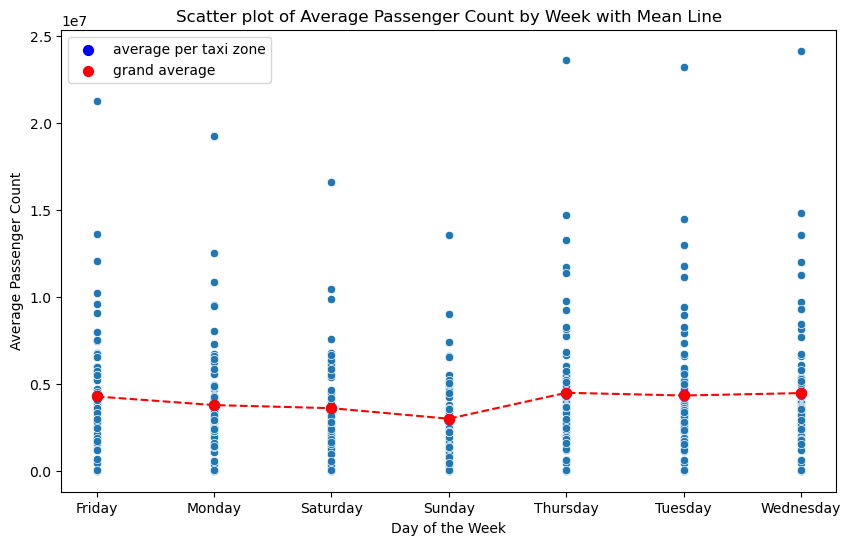

In [15]:
# Create scatter plot
plt.figure(figsize=(10,6))
sns.scatterplot(x='week', y='passenger_count', data=grouped_week)
# Calculate mean of passenger_count for each hour
mean_passenger_count = grouped_week.groupby('week')['passenger_count'].mean()
# Add circle marker to the different taxi zone values
plt.scatter(mean_passenger_count.index, mean_passenger_count.values, color='blue', s=50, label='average per taxi zone')



# Add mean line
plt.plot(mean_passenger_count.index, mean_passenger_count.values, color='red', linestyle='dashed')

# Add circle marker to the mean values
plt.scatter(mean_passenger_count.index, mean_passenger_count.values, color='red', s=50, label='grand average')

# Set plot title and labels
plt.title('Scatter plot of Average Passenger Count by Week with Mean Line')
plt.xlabel('Day of the Week')
plt.ylabel('Average Passenger Count')

# Display legend
plt.legend()

plt.show()

C:\Users\natha\anaconda3\lib\site-packages\seaborn\categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


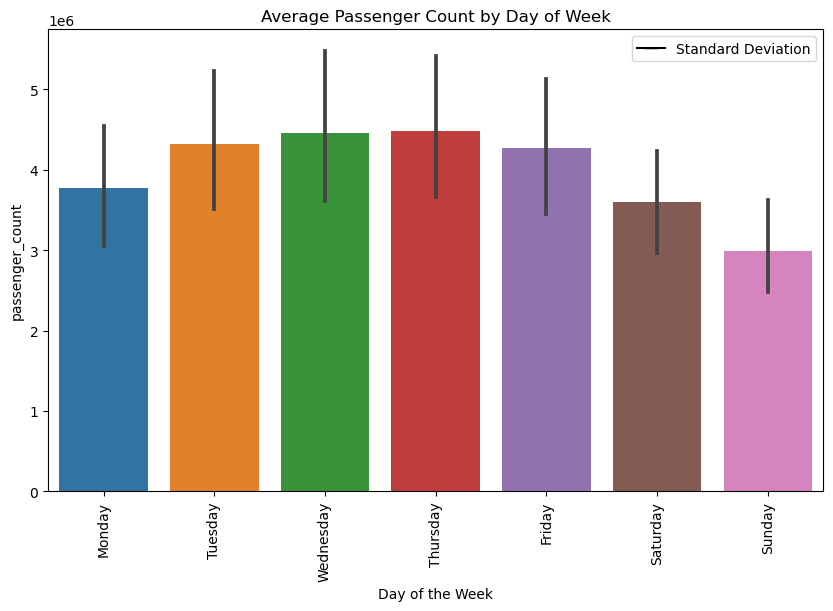

In [16]:
import matplotlib.lines as mlines

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create the bar plot with error bars
plt.figure(figsize=(10,6))
sns.barplot(x='week', y='passenger_count', data=grouped_week, order=day_order)

# Set the title and rotate the x-axis labels
plt.title('Average Passenger Count by Day of Week')
plt.xticks(rotation=90)

# Set the lower limit of y-axis to 0
plt.ylim(bottom=0)

# Create a line legend for the standard deviation
error_line = mlines.Line2D([], [], color='black', marker='_', markersize=10, label='Standard Deviation')
plt.xlabel('Day of the Week')
# Add the legend to the plot
plt.legend(handles=[error_line])

plt.show()

In [13]:
# Group by 'taxi_zone' and 'month', average 'passenger_count',
grouped_month = grouped_day.groupby(['taxi_zone', 'month']).agg({
    'passenger_count': 'sum',
    'holiday': 'first',
    'temperature_2m (°C)': 'mean',
    'rain (mm)': 'mean',
    'snow_depth (m)': 'mean',
    'snowfall (cm)': 'mean',
    'wind_speed_10m (km/h)': 'mean'
}).reset_index()


grouped_month

C:\Users\natha\AppData\Local\Temp\ipykernel_29304\2611785962.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_month = grouped_day.groupby(['taxi_zone', 'month']).agg({


,taxi_zone,month,passenger_count,holiday,temperature_2m (°C),rain (mm),snow_depth (m),snowfall (cm),wind_speed_10m (km/h)
0,4,1.0,2.153510e+06,New Year's Day,-15.104032,0.000269,0.982769,0.036835,5.615591
1,4,2.0,1.985402e+06,No,-10.911012,0.000074,1.189799,0.124740,5.226711
2,4,3.0,2.192617e+06,No,-4.554839,0.001008,1.354086,0.161263,5.543548
3,4,4.0,2.120889e+06,No,-0.147847,0.013958,1.241590,0.122549,5.793472
4,4,5.0,2.173356e+06,No,2.287769,0.080175,0.497487,0.095450,5.237702
...,...,...,...,...,...,...,...,...,...
811,263,8.0,1.491708e+06,No,8.894624,0.089247,0.000000,0.001552,5.830780
812,263,9.0,1.548847e+06,No,5.505347,0.039792,0.003181,0.023042,5.915278
813,263,10.0,1.729866e+06,No,-0.786290,0.009879,0.082695,0.106741,5.888978
814,263,11.0,1.631152e+06,No,-7.325069,0.001042,0.437972,0.080062,5.974792


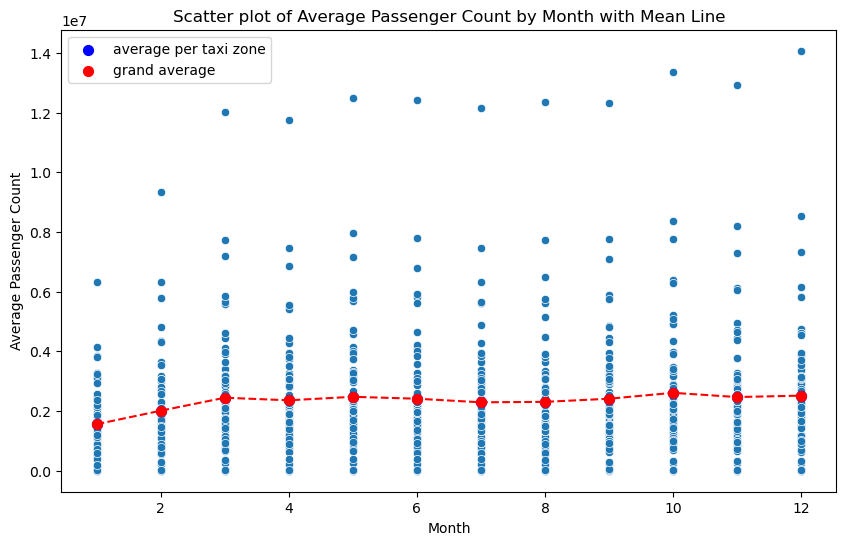

In [18]:
# Create scatter plot
plt.figure(figsize=(10,6))
sns.scatterplot(x='month', y='passenger_count', data=grouped_month)
# Calculate mean of passenger_count for each hour
mean_passenger_count = grouped_month.groupby('month')['passenger_count'].mean()
# Add circle marker to the different taxi zone values
plt.scatter(mean_passenger_count.index, mean_passenger_count.values, color='blue', s=50, label='average per taxi zone')



# Add mean line
plt.plot(mean_passenger_count.index, mean_passenger_count.values, color='red', linestyle='dashed')

# Add circle marker to the mean values
plt.scatter(mean_passenger_count.index, mean_passenger_count.values, color='red', s=50, label='grand average')

# Set plot title and labels
plt.title('Scatter plot of Average Passenger Count by Month with Mean Line')
plt.xlabel('Month')
plt.ylabel('Average Passenger Count')

# Display legend
plt.legend()

plt.show()

In [14]:
# Group by 'taxi_zone', average 'passenger_count'
grouped_day_taxi_zone = grouped_week.groupby('taxi_zone').agg({
    
    'passenger_count': 'sum',
    'holiday': 'first',
    'temperature_2m (°C)': 'mean',
    'rain (mm)': 'mean',
    'snow_depth (m)': 'mean',
    'snowfall (cm)': 'mean',
    'wind_speed_10m (km/h)': 'mean'
}).reset_index()
grouped_day_taxi_zone

C:\Users\natha\AppData\Local\Temp\ipykernel_29304\3768449121.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_day_taxi_zone = grouped_week.groupby('taxi_zone').agg({


,taxi_zone,passenger_count,holiday,temperature_2m (°C),rain (mm),snow_depth (m),snowfall (cm),wind_speed_10m (km/h)
0,4,2.564403e+07,No,-1.299492,0.039035,0.548507,0.072674,5.726584
1,12,1.911334e+07,No,-1.299492,0.039035,0.548507,0.072674,5.726584
2,13,3.957135e+07,No,-1.299492,0.039035,0.548507,0.072674,5.726584
3,24,7.719394e+06,No,-1.299492,0.039035,0.548507,0.072674,5.726584
4,41,2.411329e+07,No,-1.299492,0.039035,0.548507,0.072674,5.726584
...,...,...,...,...,...,...,...,...
63,246,2.250822e+07,No,-1.299492,0.039035,0.548507,0.072674,5.726584
64,249,3.481177e+07,No,-1.299492,0.039035,0.548507,0.072674,5.726584
65,261,2.947620e+07,No,-1.299492,0.039035,0.548507,0.072674,5.726584
66,262,1.657621e+07,No,-1.299492,0.039035,0.548507,0.072674,5.726584


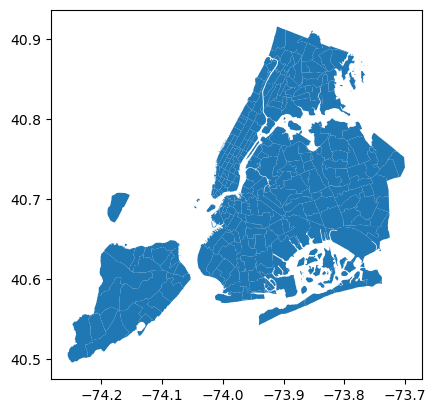

In [36]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Read the geojson file
gdf = gpd.read_file('../../datasets/raw/taxi_raw/NYC_Taxi_Zones.geojson')

# Plot the GeoDataFrame
gdf.plot()
plt.show()

In [15]:
grouped_day_taxi_zone['taxi_zone'] = grouped_day_taxi_zone['taxi_zone'].astype('object')
grouped_day_taxi_zone

,taxi_zone,passenger_count,holiday,temperature_2m (°C),rain (mm),snow_depth (m),snowfall (cm),wind_speed_10m (km/h)
0,4,2.564403e+07,No,-1.299492,0.039035,0.548507,0.072674,5.726584
1,12,1.911334e+07,No,-1.299492,0.039035,0.548507,0.072674,5.726584
2,13,3.957135e+07,No,-1.299492,0.039035,0.548507,0.072674,5.726584
3,24,7.719394e+06,No,-1.299492,0.039035,0.548507,0.072674,5.726584
4,41,2.411329e+07,No,-1.299492,0.039035,0.548507,0.072674,5.726584
...,...,...,...,...,...,...,...,...
63,246,2.250822e+07,No,-1.299492,0.039035,0.548507,0.072674,5.726584
64,249,3.481177e+07,No,-1.299492,0.039035,0.548507,0.072674,5.726584
65,261,2.947620e+07,No,-1.299492,0.039035,0.548507,0.072674,5.726584
66,262,1.657621e+07,No,-1.299492,0.039035,0.548507,0.072674,5.726584


In [16]:
import geopandas as gpd
from geopandas import GeoDataFrame
import folium
from folium.plugins import HeatMap

# Merge GeoDataFrame and DataFrame
gdf['location_id'] = gdf['location_id'].astype('int')
merged = gdf.set_index('location_id').join(grouped_day_taxi_zone.set_index('taxi_zone'))
gdf['location_id'] = gdf['location_id'].astype('object')

merged

# add 1 for log transformation
merged['passenger_count'] = merged['passenger_count'] + 1

NameError: name 'gdf' is not defined

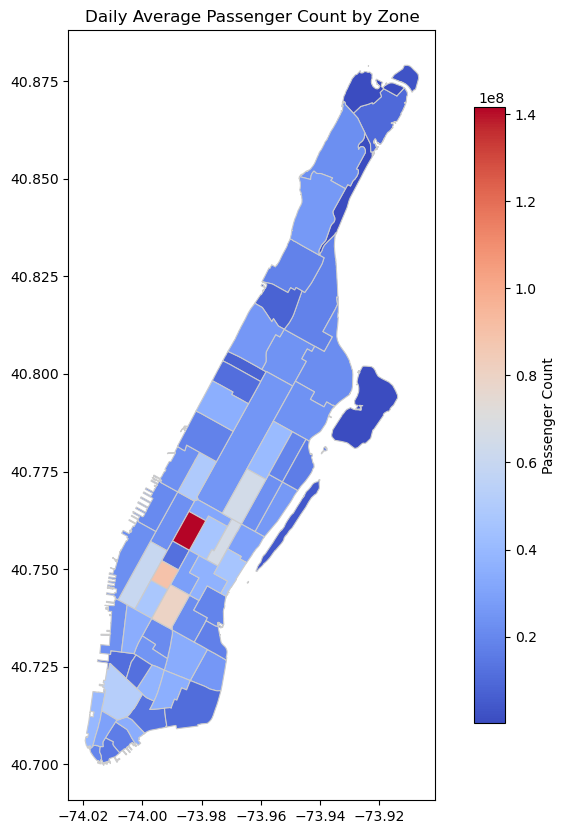

In [38]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

merged.plot(column='passenger_count', 
            cmap='coolwarm', 
            linewidth=0.8, 
            ax=ax, 
            edgecolor='0.8',
            legend=True,
            legend_kwds={'label': "Passenger Count",
                         'orientation': "vertical",
                         'shrink': 0.8})

# Set the title
plt.title('Daily Average Passenger Count by Zone')
plt.show()

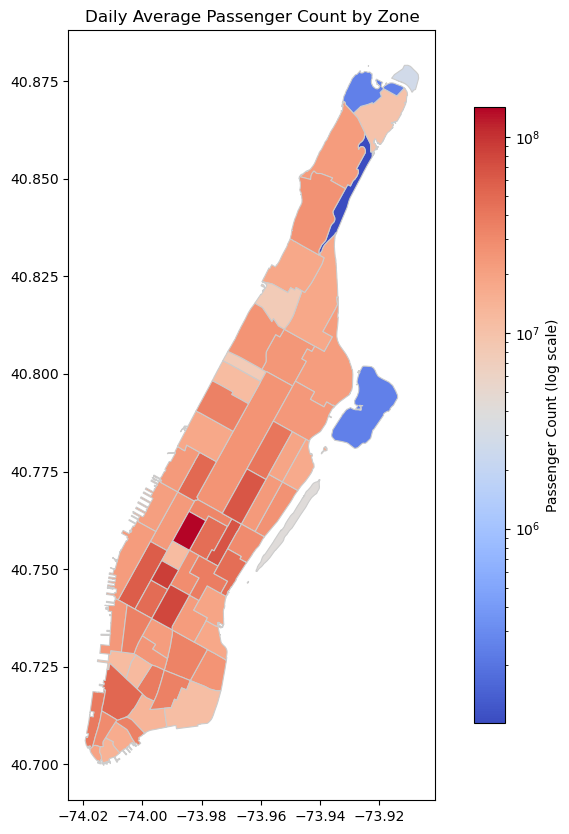

In [39]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Use a logarithmic color scale
norm = colors.LogNorm(vmin=merged['passenger_count'].min(), vmax=merged['passenger_count'].max())

merged.plot(column='passenger_count', 
            cmap='coolwarm', 
            linewidth=0.8, 
            ax=ax, 
            edgecolor='0.8',
            legend=True,
            norm=norm,
            legend_kwds={'label': "Passenger Count (log scale)",
                         'orientation': "vertical",
                         'shrink': 0.8})

# Set the title
plt.title('Daily Average Passenger Count by Zone')

plt.show()

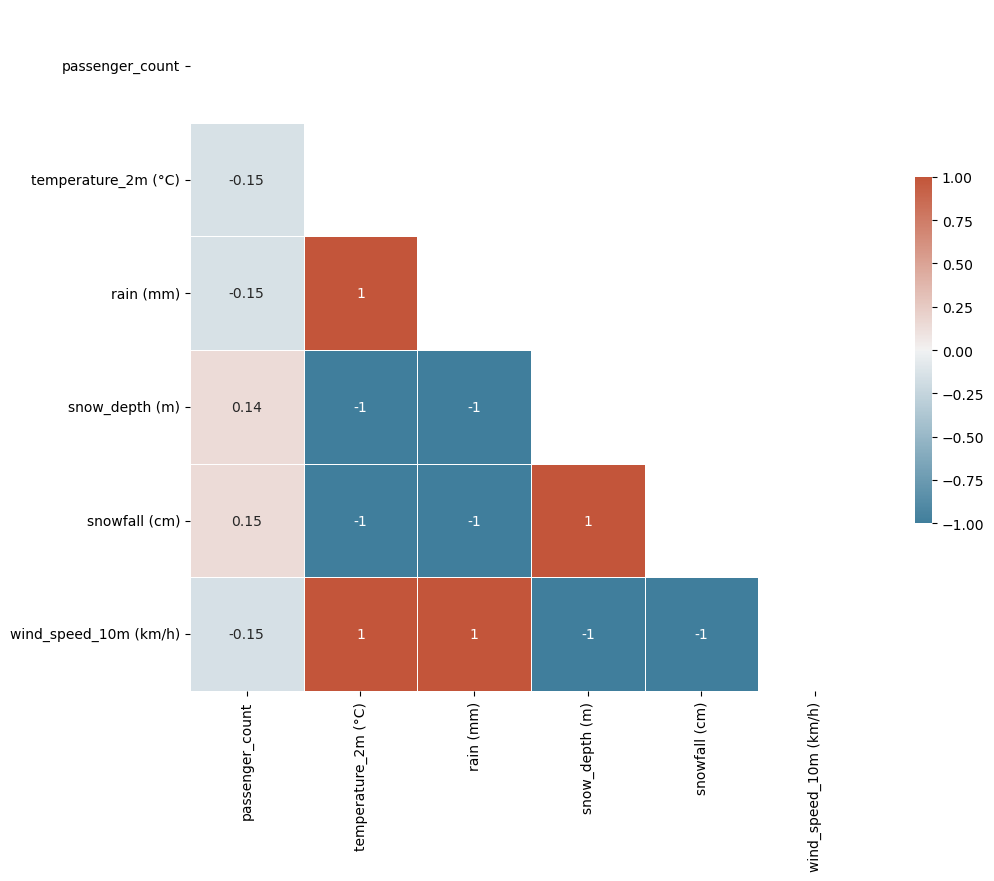

In [40]:
# Select only numeric columns
grouped_day_taxi_zone_numeric_cols = grouped_day_taxi_zone.select_dtypes(include=[np.number])

# Calculate the correlation matrix
corr = grouped_day_taxi_zone_numeric_cols.corr()


# Generate a mask for the upper triangle (optional)
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

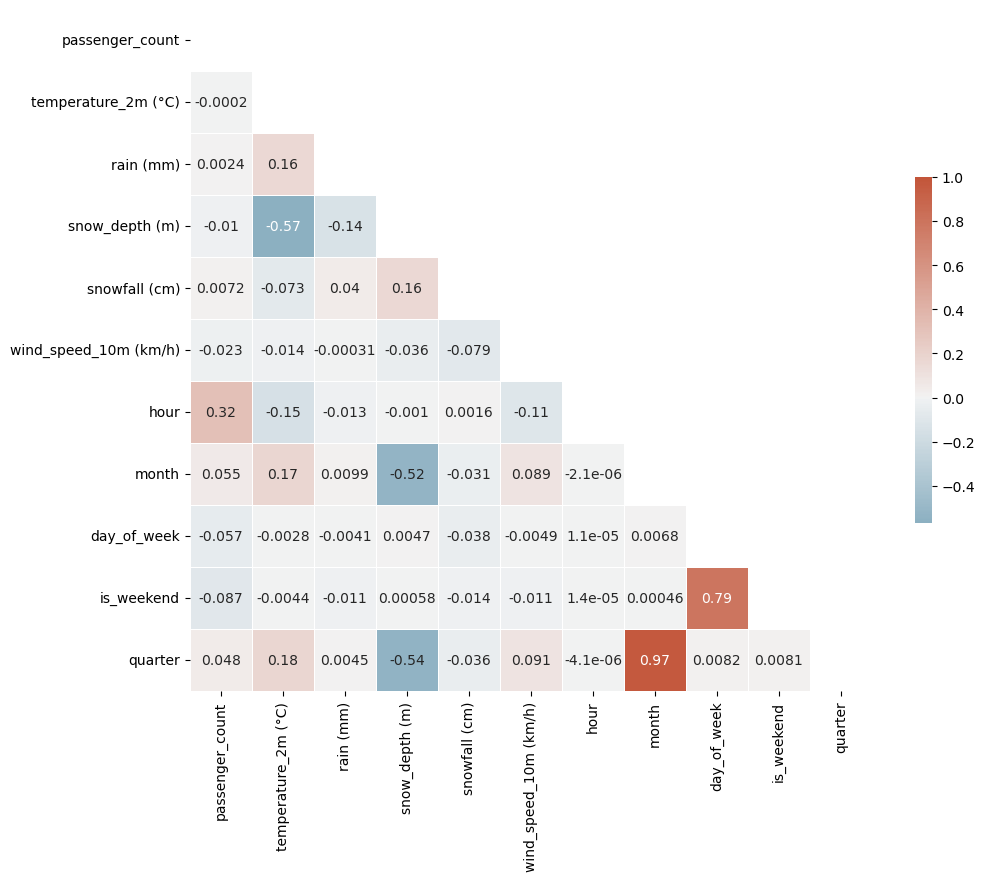

In [41]:
# Select only the numerical columns from the dataframe
df_numerical_features = df.select_dtypes(include=[np.number])

# Compute the correlation matrix
corr = df_numerical_features.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

In [42]:
grouped_day_holiday = grouped_day.groupby(['holiday']).agg({
    'passenger_count': 'sum',
    'temperature_2m (°C)': 'mean',
    'rain (mm)': 'mean',
    'snow_depth (m)': 'mean',
    'snowfall (cm)': 'mean',
    'wind_speed_10m (km/h)': 'mean'
}).reset_index()
grouped_day_holiday

C:\Users\natha\AppData\Local\Temp\ipykernel_30152\271133746.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_day_holiday = grouped_day.groupby(['holiday']).agg({


,holiday,passenger_count,temperature_2m (°C),rain (mm),snow_depth (m),snowfall (cm),wind_speed_10m (km/h)
0,Christmas Day,2.711956e+06,-12.650000,0.000000,0.818333,0.000000,7.516667
1,Christmas Day (observed),1.797993e+06,-16.612500,0.000000,1.046250,0.000000,6.208333
2,Columbus Day,4.798343e+06,0.881250,0.006250,0.001875,0.000000,5.825000
3,Independence Day,3.251890e+06,11.331250,0.120833,0.000000,0.000000,6.525000
4,Juneteenth National Independence Day,4.172171e+06,6.810370,0.198966,0.000000,0.000000,5.952757
5,Juneteenth National Independence Day (observed),2.209476e+06,6.141667,0.425000,0.000000,0.029167,4.016667
6,Labor Day,3.521122e+06,6.708333,0.083333,0.000000,0.058333,6.627083
7,Martin Luther King Jr. Day,2.789851e+06,-15.604167,0.000000,0.997292,0.008750,6.433333
8,Memorial Day,3.570486e+06,1.606250,0.027083,0.191042,0.026250,5.054167
9,New Year's Day,2.769812e+06,-13.889583,0.000000,0.845833,0.026250,5.408333


In [43]:
# Get the unique values of the 'holiday' column
unique_holidays = grouped_day_holiday['holiday'].unique()

# Print the unique values
unique_holidays.tolist()

['Christmas Day',
 'Christmas Day (observed)',
 'Columbus Day',
 'Independence Day',
 'Juneteenth National Independence Day',
 'Juneteenth National Independence Day (observed)',
 'Labor Day',
 'Martin Luther King Jr. Day',
 'Memorial Day',
 "New Year's Day",
 "New Year's Day (observed)",
 'No',
 'Thanksgiving',
 'Veterans Day',
 'Veterans Day (observed)',
 "Washington's Birthday"]

C:\Users\natha\anaconda3\lib\site-packages\seaborn\categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


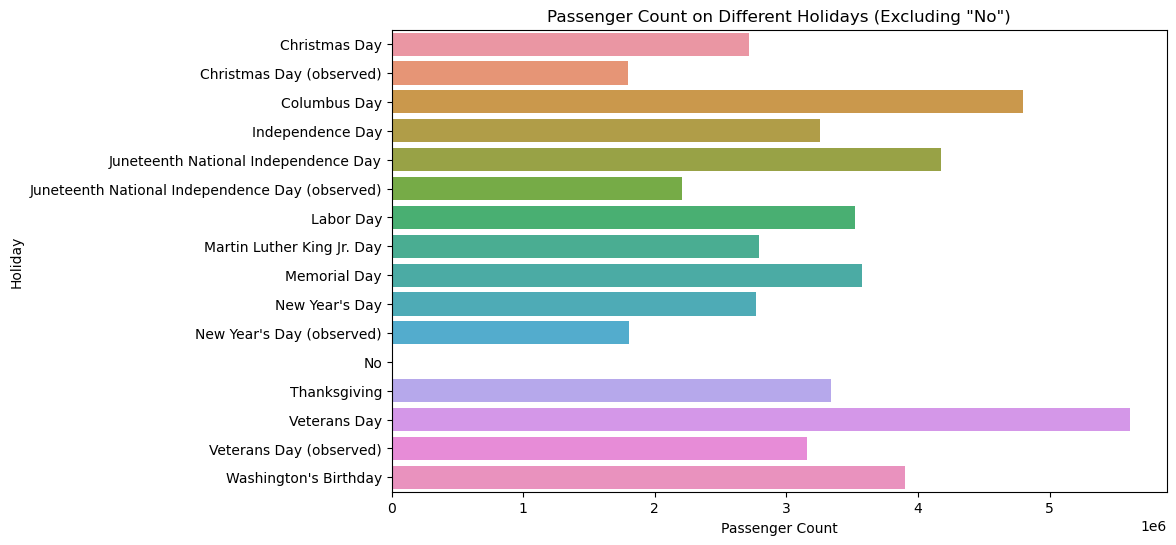

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size
plt.figure(figsize=(10, 6))

hol_list = ['Christmas Day',
            'Christmas Day (observed)',
            'Columbus Day',
            'Independence Day',
            'Juneteenth National Independence Day',
            'Juneteenth National Independence Day (observed)',
            'Labor Day',
            'Martin Luther King Jr. Day',
            'Memorial Day',
            "New Year's Day",
            "New Year's Day (observed)",
            'Thanksgiving',
            'Veterans Day',
            'Veterans Day (observed)',
            "Washington's Birthday"]

# Filter grouped_day_holiday to include only holidays in hol_list
filtered_data = grouped_day_holiday[grouped_day_holiday['holiday'].isin(hol_list)]

# Create barplot
sns.barplot(x='passenger_count', y='holiday', data=filtered_data)

# Set the title and labels
plt.title('Passenger Count on Different Holidays (Excluding "No")')
plt.xlabel('Passenger Count')
plt.ylabel('Holiday')
# Show the plot
plt.show()

C:\Users\natha\anaconda3\lib\site-packages\seaborn\categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


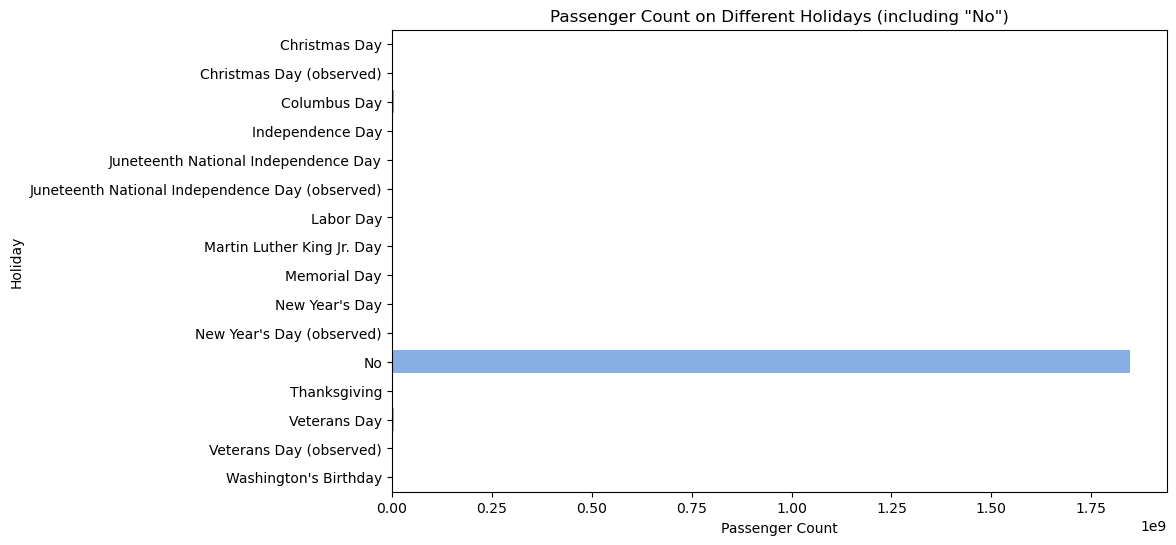

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size
plt.figure(figsize=(10, 6))

hol_list = ['Christmas Day',
            'Christmas Day (observed)',
            'Columbus Day',
            'Independence Day',
            'Juneteenth National Independence Day',
            'Juneteenth National Independence Day (observed)',
            'Labor Day',
            'Martin Luther King Jr. Day',
            'Memorial Day',
            'No',
            "New Year's Day",
            "New Year's Day (observed)",
            'Thanksgiving',
            'Veterans Day',
            'Veterans Day (observed)',
            "Washington's Birthday"]

# Filter grouped_day_holiday to include only holidays in hol_list
filtered_data = grouped_day_holiday[grouped_day_holiday['holiday'].isin(hol_list)]

# Create barplot
sns.barplot(x='passenger_count', y='holiday', data=filtered_data)

# Set the title and labels
plt.title('Passenger Count on Different Holidays (including "No")')
plt.xlabel('Passenger Count')
plt.ylabel('Holiday')

# Show the plot
plt.show()

In [46]:
grouped_day['rest_day'] = 1

# function to check if it's a weekend or holiday
def is_rest_day(row):
    # Check if it's Saturday or Sunday (week in range 5-6) or if it's a holiday
    if (row['week'] in ['Saturday', 'Sunday']) or (row['holiday'] != 'No'):
        return 1
    else:
        return 0

# Apply the function row-wise to create the 'rest_day' column
grouped_day['rest_day'] = grouped_day.apply(is_rest_day, axis=1)

# Display the updated DataFrame with the new 'rest_day' column
grouped_day

,taxi_zone,date,passenger_count,week,month,holiday,temperature_2m (°C),rain (mm),snow_depth (m),snowfall (cm),wind_speed_10m (km/h),rest_day
0,4,2022-01-01,34910.760870,Saturday,1.0,New Year's Day,-11.141667,0.000000,0.645833,0.049583,5.812500,1
1,4,2022-01-02,32890.000000,Sunday,1.0,No,-10.945833,0.000000,0.648750,0.017500,5.737500,1
2,4,2022-01-03,32852.847826,Monday,1.0,No,-9.212500,0.000000,0.641250,0.032083,6.904167,0
3,4,2022-01-04,31432.978261,Tuesday,1.0,No,-8.483333,0.000000,0.675000,0.151667,3.683333,0
4,4,2022-01-05,31501.239130,Wednesday,1.0,No,-9.983333,0.000000,0.683750,0.014583,4.225000,0
...,...,...,...,...,...,...,...,...,...,...,...,...
49635,263,2023-12-27,19219.000000,Wednesday,12.0,No,-7.325000,0.000000,0.750833,0.772917,6.887500,0
49636,263,2023-12-28,21988.000000,Thursday,12.0,No,-7.033333,0.000000,0.849167,0.000000,8.812500,0
49637,263,2023-12-29,23156.000000,Friday,12.0,No,-8.295833,0.008333,0.845000,0.253750,7.091667,0
49638,263,2023-12-30,21776.000000,Saturday,12.0,No,-14.895833,0.000000,0.902083,0.099167,4.120833,1


In [47]:
grouped_day_rest_day = grouped_day.groupby('rest_day')['passenger_count'].mean().reset_index()
grouped_day_rest_day

,rest_day,passenger_count
0,0,42065.967455
1,1,30170.567852


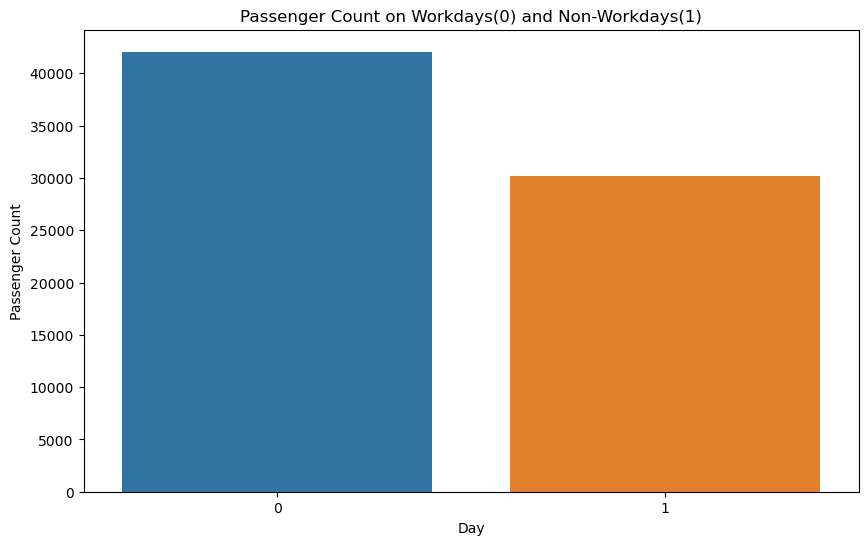

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(10,6))

# Create barplot
sns.barplot(x='rest_day', y='passenger_count', data=grouped_day_rest_day)

# Set the title and labels
plt.title('Passenger Count on Workdays(0) and Non-Workdays(1)')
plt.xlabel('Day')
plt.ylabel('Passenger Count')

# Show the plot
plt.show()

In [17]:
#calculate mean and standard deviation for each taxi zone by day and hour
zone_stats = df.groupby(['taxi_zone', 'day', 'hour'])['passenger_count'].agg(['mean', 'std']).reset_index()

# merge stats back to df
df = df.merge(zone_stats, on=['taxi_zone', 'day', 'hour'], how='left')

#z-score for each passenger count
df['z_score'] = (df['passenger_count'] - df['mean']) / df['std']

#busyness index (scale 1 to 5)
def z_to_index(z):
    if z <= -1.5:
        return 1
    elif z <= -0.5:
        return 2
    elif z <= 0.5:
        return 3
    elif z <= 1.5:
        return 4
    else:
        return 5

df['busyness_index'] = df['z_score'].apply(z_to_index)

# Drop unnecessary columns
df = df.drop(columns=['mean', 'std', 'z_score'])

C:\Users\natha\AppData\Local\Temp\ipykernel_29304\589907917.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  zone_stats = df.groupby(['taxi_zone', 'day', 'hour'])['passenger_count'].agg(['mean', 'std']).reset_index()


In [18]:
df.head()

,datetime,taxi_zone,passenger_count,temperature_2m (°C),rain (mm),snow_depth (m),snowfall (cm),wind_speed_10m (km/h),day,week,hour,month,holiday,day_of_week,is_weekend,quarter,date,busyness_index
0,2022-01-01 00:00:00,4,890.500000,-17.0,0.0,0.64,0.00,8.3,1,Saturday,0,1,New Year's Day,5,1,1,2022-01-01,3
1,2022-01-01 01:00:00,4,793.239130,-15.6,0.0,0.64,0.07,8.0,1,Saturday,1,1,New Year's Day,5,1,1,2022-01-01,4
2,2022-01-01 02:00:00,4,686.500000,-14.7,0.0,0.64,0.07,7.6,1,Saturday,2,1,New Year's Day,5,1,1,2022-01-01,4
3,2022-01-01 03:00:00,4,523.891304,-14.2,0.0,0.64,0.07,7.0,1,Saturday,3,1,New Year's Day,5,1,1,2022-01-01,5
4,2022-01-01 04:00:00,4,351.956522,-12.6,0.0,0.64,0.14,7.0,1,Saturday,4,1,New Year's Day,5,1,1,2022-01-01,5


C:\Users\natha\AppData\Local\Temp\ipykernel_29304\834241254.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = df.pivot_table(index='hour', columns='week', values='busyness_index', aggfunc='mean')


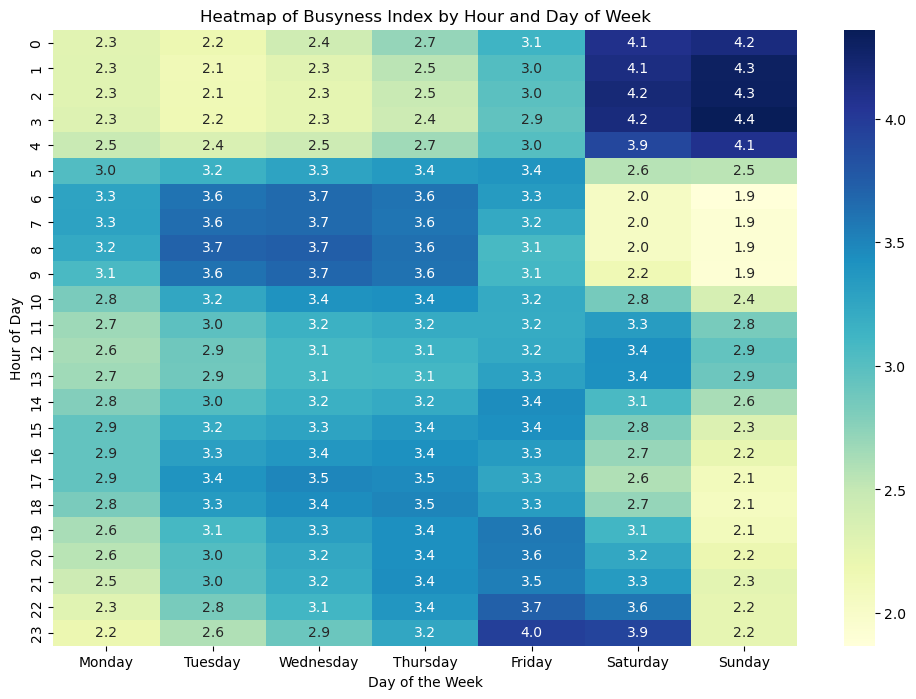

In [20]:
# pivot table for the heatmap
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['week'] = pd.Categorical(df['week'], categories=day_order, ordered=True)

heatmap_data = df.pivot_table(index='hour', columns='week', values='busyness_index', aggfunc='mean')
plt.figure(figsize=(12, 8))

sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt=".1f")

plt.title('Heatmap of Busyness Index by Hour and Day of Week')
plt.xlabel('Day of the Week')
plt.ylabel('Hour of Day')

plt.show()

<Figure size 1200x800 with 0 Axes>

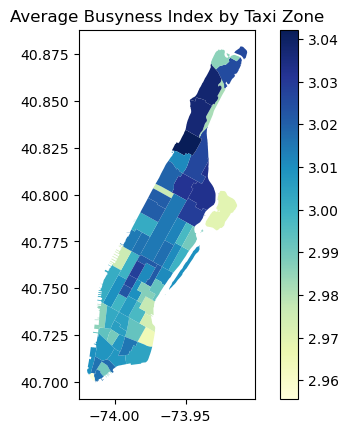

In [71]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Read the geojson file
gdf = gpd.read_file('NYC_Taxi_Zones.geojson')

# Calculate average busyness index for each taxi zone
zone_avg_busyness = df.groupby('taxi_zone')['busyness_index'].mean().reset_index()

# Merge with the GeoDataFrame
gdf['location_id'] = gdf['location_id'].astype('int')
gdf = gdf.set_index('location_id').join(zone_avg_busyness.set_index('taxi_zone'))


# Plot the GeoDataFrame
plt.figure(figsize=(12, 8))
gdf.plot(column='busyness_index', cmap='YlGnBu', legend=True)
plt.title('Average Busyness Index by Taxi Zone')
plt.show()

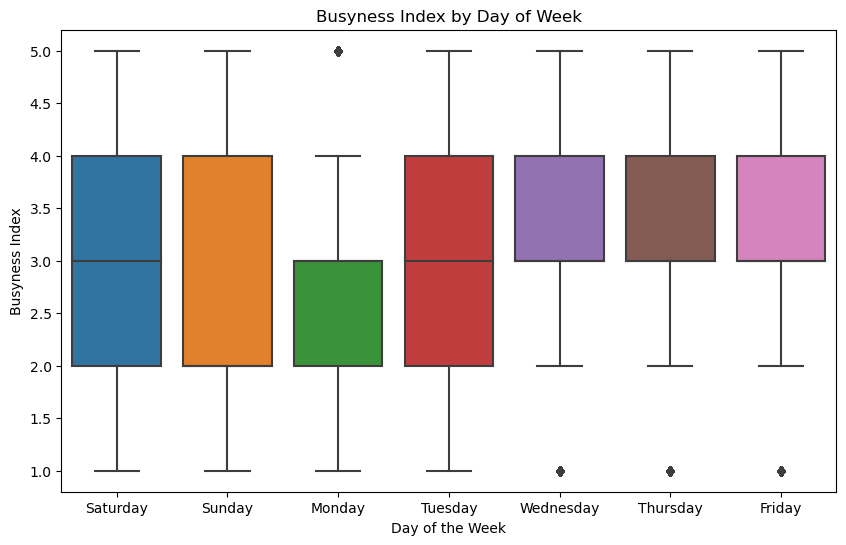

In [67]:
# Plot the box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='week', y='busyness_index', data=df)

# Set the title and labels
plt.title('Busyness Index by Day of Week')
plt.xlabel('Day of the Week')
plt.ylabel('Busyness Index')

# Show the plot
plt.show()

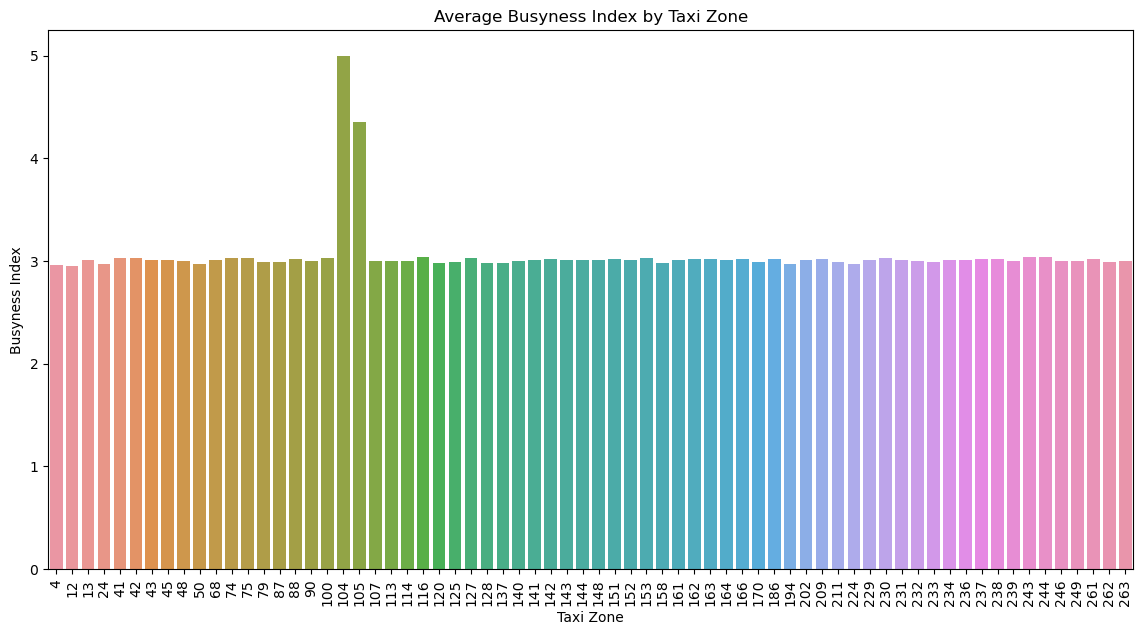

In [68]:
# Calculate average busyness index for each taxi zone
zone_avg_busyness = df.groupby('taxi_zone')['busyness_index'].mean().reset_index()
plt.figure(figsize=(14, 7))
sns.barplot(x='taxi_zone', y='busyness_index', data=zone_avg_busyness)

plt.title('Average Busyness Index by Taxi Zone')
plt.xlabel('Taxi Zone')
plt.ylabel('Busyness Index')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)
plt.show()

In [72]:
df = df.to_csv('basic_prepared_data_2.csv', index=False)

In [73]:
df = pd.read_csv('basic_prepared_data_2.csv', keep_default_na=True, delimiter=',', skipinitialspace=True)
df.head()

,datetime,taxi_zone,passenger_count,temperature_2m (°C),rain (mm),snow_depth (m),snowfall (cm),wind_speed_10m (km/h),day,week,hour,month,holiday,day_of_week,is_weekend,quarter,date,busyness_index
0,2022-01-01 00:00:00,4,890.500000,-17.0,0.0,0.64,0.00,8.3,1,Saturday,0,1,New Year's Day,5,1,1,2022-01-01,3
1,2022-01-01 01:00:00,4,793.239130,-15.6,0.0,0.64,0.07,8.0,1,Saturday,1,1,New Year's Day,5,1,1,2022-01-01,4
2,2022-01-01 02:00:00,4,686.500000,-14.7,0.0,0.64,0.07,7.6,1,Saturday,2,1,New Year's Day,5,1,1,2022-01-01,4
3,2022-01-01 03:00:00,4,523.891304,-14.2,0.0,0.64,0.07,7.0,1,Saturday,3,1,New Year's Day,5,1,1,2022-01-01,5
4,2022-01-01 04:00:00,4,351.956522,-12.6,0.0,0.64,0.14,7.0,1,Saturday,4,1,New Year's Day,5,1,1,2022-01-01,5
